# nomao dataset 

In [10]:
# Imports
import numpy as np
import pandas as pd

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval import (
    AME,
    DVRL,
    BetaShapley,
    DataBanzhaf,
    DataOob,
    DataShapley,
    InfluenceSubsample,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)

from opendataval.experiment import ExperimentMediator

import warnings
warnings.filterwarnings("ignore")

## [Step 1] Set up an environment
`ExperimentMediator` is a fundamental concept in establishing the `opendataval` environment. It empowers users to configure hyperparameters, including a dataset, a type of synthetic noise, and a prediction model. With  `ExperimentMediator`, users can effortlessly compute various data valuation algorithms.

The following code cell demonstrates how to set up `ExperimentMediator` with a pre-registered dataset and a prediction model.
- Dataset: nomao
- Model: sklearn's logistic regression model
- Metric: F1-score

In [11]:
dataset_name = "nomao"
train_count, valid_count, test_count = 1000, 100, 500
noise_rate = 0.2
noise_kwargs = {'noise_rate': noise_rate}
model_name = "sklogreg"
metric_name = "accuracy"

exper_med = ExperimentMediator.model_factory_setup(
    dataset_name=dataset_name,
    cache_dir="../data_files/",  
    force_download=False,
    train_count=train_count,
    valid_count=valid_count,
    test_count=test_count,
    add_noise=mix_labels, 
    noise_kwargs=noise_kwargs,
    train_kwargs={},
    model_name=model_name,
    metric_name=metric_name
)

Base line model metric_name='accuracy': perf=0.8820000290870667


A full list of registered datasets can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/dataloader/fetcher.py#L121). A list of available  prediction models can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/model/__init__.py#L111).

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [12]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceSubsample(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
#     DataShapley(gr_threshold=1.05, cache_name=f"cached"), # Data-Shapley
#     BetaShapley(gr_threshold=1.05, cache_name=f"cached"), # Beta-Shapley
    DataBanzhaf(num_models=1000), # Data-Banzhaf
#     AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000), # Data-OOB
    LavaEvaluator(),
#     RobustVolumeShapley(gr_threshold=1.05)
]

In [13]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.001156


100%|██████████| 1000/1000 [00:19<00:00, 51.33it/s]


Elapsed time LeaveOneOut(): 0:00:19.608131


100%|██████████| 1000/1000 [00:16<00:00, 61.00it/s]


Elapsed time InfluenceSubsample(num_models=1000): 0:00:16.397539


100%|██████████| 2000/2000 [00:03<00:00, 618.11it/s]


Elapsed time DVRL(rl_epochs=2000): 0:00:03.268166


100%|██████████| 999/999 [00:00<00:00, 13782.76it/s]


Elapsed time KNNShapley(k_neighbors=100): 0:00:00.101607


100%|██████████| 1000/1000 [00:11<00:00, 85.37it/s]


Elapsed time DataBanzhaf(num_models=1000): 0:00:11.738349


100%|██████████| 1000/1000 [00:25<00:00, 38.52it/s]


Elapsed time DataOob(num_models=1000): 0:00:25.968331


Elapsed time LavaEvaluator(): 0:00:00.269519
CPU times: user 12min 46s, sys: 1min 17s, total: 14min 3s
Wall time: 1min 17s


## [Step 3] Evaluate data values

In [14]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/nomao_noise_rate=0.2/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: mislabeled data

In [15]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
DVRL(rl_epochs=2000),0.609174
DataBanzhaf(num_models=1000),0.293948
DataOob(num_models=1000),0.741803
InfluenceSubsample(num_models=1000),0.307471
KNNShapley(k_neighbors=100),0.510638
LavaEvaluator(),0.045455
LeaveOneOut(),0.194093
RandomEvaluator(),0.294278


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

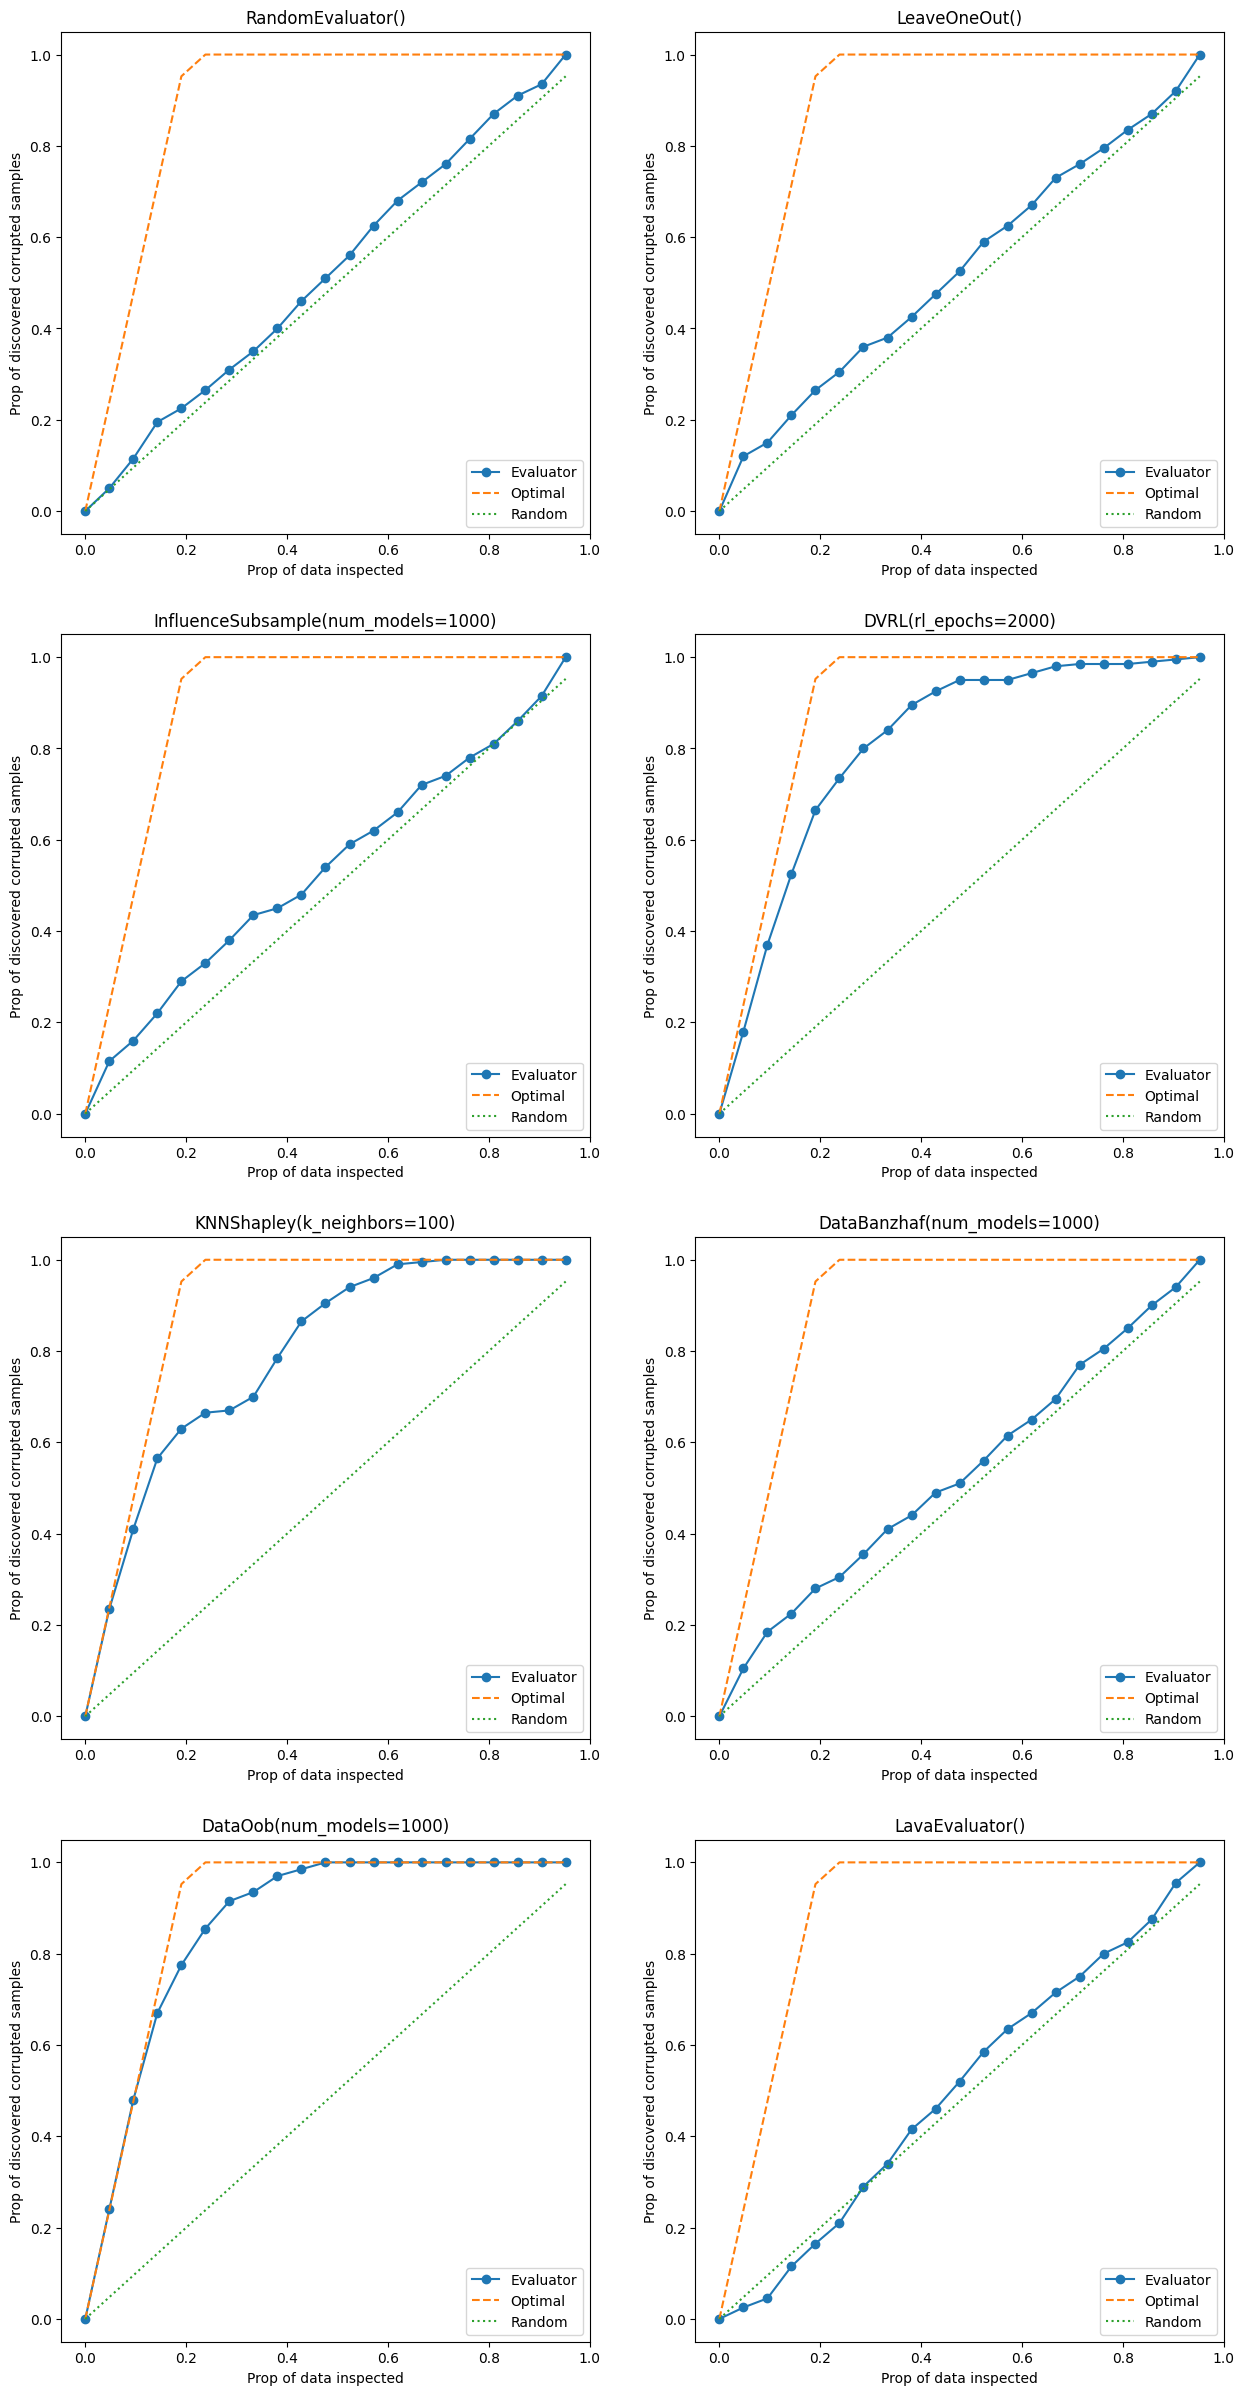

In [16]:
fig = plt.figure(figsize=(15, 30))
df, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

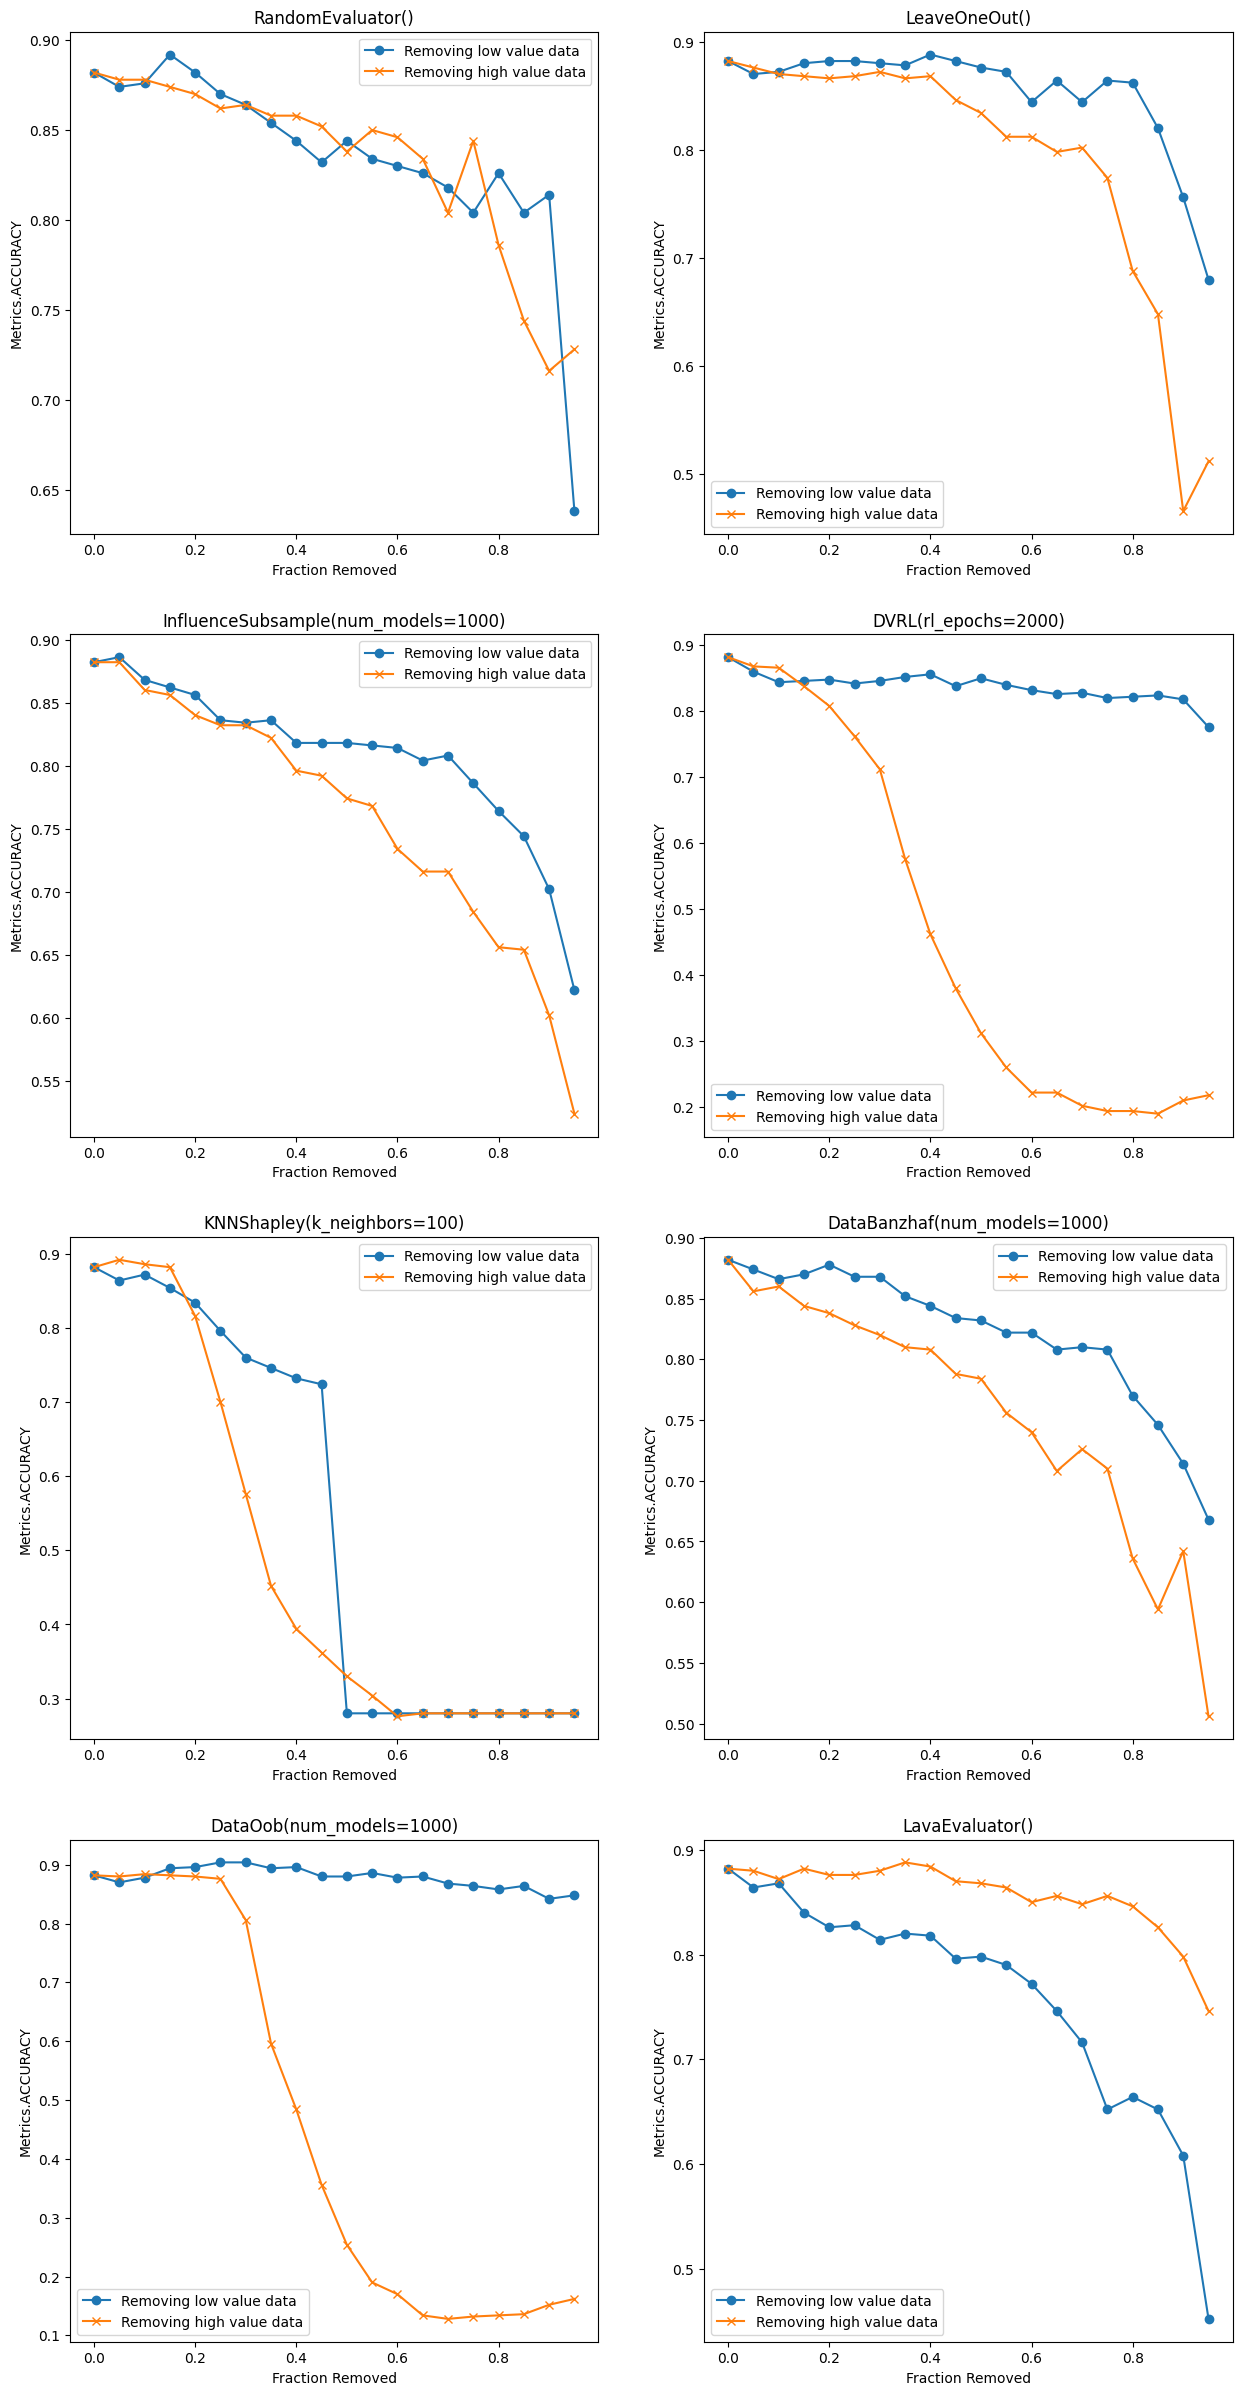

In [17]:
fig = plt.figure(figsize=(15, 30))
df_resp, fig = exper_med.plot(remove_high_low, fig, col=2, save_output=True)

In [18]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.ACCURACY,remove_most_influential_first_Metrics.ACCURACY,axis
RandomEvaluator(),0.882,0.882,0.0
RandomEvaluator(),0.874,0.878,0.05
RandomEvaluator(),0.876,0.878,0.1
RandomEvaluator(),0.892,0.874,0.15
RandomEvaluator(),0.882,0.87,0.2
...,...,...,...
LavaEvaluator(),0.652,0.856,0.75
LavaEvaluator(),0.664,0.846,0.8
LavaEvaluator(),0.652,0.826,0.85
LavaEvaluator(),0.608,0.798,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [19]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),5042,0.49439
RandomEvaluator(),13036,0.451617
RandomEvaluator(),18315,0.074966
RandomEvaluator(),4835,0.225464
RandomEvaluator(),9655,0.574953
...,...,...
LavaEvaluator(),21308,13.033386
LavaEvaluator(),5940,11.610572
LavaEvaluator(),6434,12.974161
LavaEvaluator(),27413,7.180464
